In [1]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split 
from keras.layers import Embedding, Bidirectional, LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [3]:
data_path = "C:/Users/Ideapad Gaming 3/Desktop/MINOR 1 FINAL/dataraw.csv"
data = pd.read_csv(data_path)

In [4]:
print(data)

      Unnamed: 0            id  \
0              0  1.120000e+18   
1              1  1.120000e+18   
2              2  1.120000e+18   
3              3  1.120000e+18   
4              4  1.120000e+18   
...          ...           ...   
3511        3511  1.120000e+18   
3512        3512  1.120000e+18   
3513        3513  1.120000e+18   
3514        3514  1.120000e+18   
3515        3515  1.120000e+18   

                                                   text  anger  insult  joy  \
0     Voting turnout (in percentage) recorded till 3...      0       0    0   
1     #LokSabhaElections2019  wife &amp; Siya (2.5 y...      0       0    1   
2     #AayegaToModiHi #LokSabhaElections2019\nToday ...      0       0    1   
3     All those journalists who defend the integrity...      1       1    0   
4     Polling underway in the third phase of #LokSab...      0       0    0   
...                                                 ...    ...     ...  ...   
3511  raga   the story of 3 cs.  citiz

In [5]:
data['text'] = data['text'].str.lower() #cleaning

In [6]:
df = pd.DataFrame(data, columns = ["sr","id","text","neutral","anger","sadness","joy","surprise","insult"])

In [7]:
df.head()

,sr,id,text,neutral,anger,sadness,joy,surprise,insult
0,NaN,1.120000e+18,voting turnout (in percentage) recorded till 3...,1,0,0,0,0,0
1,NaN,1.120000e+18,#loksabhaelections2019 wife &amp; siya (2.5 y...,1,0,0,1,1,0
2,NaN,1.120000e+18,#aayegatomodihi #loksabhaelections2019\ntoday ...,0,0,0,1,0,0
3,NaN,1.120000e+18,all those journalists who defend the integrity...,0,1,1,0,0,1
4,NaN,1.120000e+18,polling underway in the third phase of #loksab...,1,0,0,0,0,0


In [8]:
categories = list(df.columns.values)
categories = categories[3:]
print(categories)


['neutral', 'anger', 'sadness', 'joy', 'surprise', 'insult']


In [9]:
counts = []
for category in categories:
        counts.append((category,df[category].sum()))
df_stats = pd.DataFrame(counts,columns=['category','number of comments'])
df_stats

,category,number of comments
0,neutral,2610
1,anger,269
2,sadness,625
3,joy,1607
4,surprise,236
5,insult,1446


In [10]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to C:\Users\Ideapad Gaming
[nltk_data]     3\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
import re

In [12]:
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)
data['text']=data['text'].apply(str) #some of the values that appear to be float need to be converted to strings to avoid error
data['text'] = data['text'].apply(removeStopWords)
data.head()

,Unnamed: 0,id,text,anger,insult,joy,neutral,sadness,surprise
0,0,1.120000e+18,voting turnout ( percentage) recorded till 3 p...,0,0,0,1,0,0
1,1,1.120000e+18,#loksabhaelections2019 wife &amp; siya (2.5 y...,0,0,1,1,0,1
2,2,1.120000e+18,#aayegatomodihi #loksabhaelections2019\ntoday ...,0,0,1,0,0,0
3,3,1.120000e+18,journalists defend integrity sanctity ev...,1,1,0,0,1,0
4,4,1.120000e+18,polling underway third phase #loksabhaelect...,0,0,0,1,0,0


In [13]:
train, test = train_test_split(data, random_state=42, test_size=0.30, shuffle=True)
#random state = 42 is basically passing same training testing data across all iterations
print(train.shape)
print(test.shape)

(2461, 9)
(1055, 9)


In [14]:
train_text = train['text']
test_text = test['text']

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(train_text)
vectorizer.fit(test_text)

TfidfVectorizer(ngram_range=(1, 3), strip_accents='unicode')

In [16]:
x_train = vectorizer.transform(train_text)
y_train = train.drop(labels = ['id','text'], axis=1)

x_test = vectorizer.transform(test_text)
y_test = test.drop(labels = ['id','text'], axis=1)

In [17]:
import os
import numpy as np
import pandas as pd

In [18]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2
EPOCHS = 10

In [21]:
word2vec = {}
with open(os.path.join('embeddings/wiki-news-300d-1M.vec'),encoding = "utf-8") as f:
    
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:],dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Found 999995 word vectors.


In [22]:
from __future__ import print_function,division
from builtins import range

In [23]:
train = data
sentences = train["text"].fillna("DUMMY_VALUE").values
#possible_labels = ["Joy","Satisfaction","neutral","sadness","surprise","insult","shame"]
possible_labels = ["neutral","anger","sadness","joy","surprise","insult"]
targets = train[possible_labels].values


In [24]:
print(sentences.shape)
print(targets.shape)

(3516,)
(3516, 6)


In [25]:
print("max len seq:",max(len(s) for s in sentences))
print("min len seq:",min(len(s) for s in sentences))
s = sorted(len(s) for s in sentences)
print("Median seq len:",s[len(s)//2])

max len seq: 303
min len seq: 1
Median seq len: 119


In [26]:
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences) 
sequences = tokenizer.texts_to_sequences(sentences)

print("max len seq:",max(len(s) for s in sequences))
print("min len seq:",min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("Median seq len:",s[len(s)//2])

print("max word index:",max(max(seq) for seq in sequences if len(seq)>0))

max len seq: 53
min len seq: 0
Median seq len: 13
max word index: 14933


In [27]:
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 14933 unique tokens.


In [28]:
data= pad_sequences(sequences, maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:',data.shape)
print(data)

Shape of data tensor: (3516, 100)
[[    0     0     0 ...     1     2  4897]
 [    0     0     0 ...     1     2  4898]
 [    0     0     0 ...     1     2  2951]
 ...
 [    0     0     0 ...     1     2 14928]
 [    0     0     0 ...     1     2 14930]
 [    0     0     0 ...     1     2 14933]]


What is an Embedding Matrix?
Take three similar phrases:

… when the worker left …
… when the fisherman left …
… when the dog left …

Now, imagine we don’t know what “worker,” “fisherman,” and “dog” mean. In fact, we don’t know any of the words, but can easily tell that the phrases are identical except for one word. Since the contexts are identical, we could extrapolate that some similarity exists between “worker,” “fisherman,” and “dog”. By applying this idea to an entire corpus, we could define the relationships between words. Then we come to the question of how best to represent those relationships in a general way.

The concept of an embedding matrix is an attempt to solve this relationship representation problem. To begin with, we pick a dimensionality of meaning — this can be somewhat arbitrary. Say we decide all meaning can map to some abstract space of three dimensions. Conceptually, that would mean that all words would exist as singular points in a 3D space and any word could be uniquely defined by their position within that space described by three numbers (x, y, z). But, in reality, meaning is too complicated to fit well into three dimensions. Typically, we use something like 300 dimensions, and all words map to some point in this 300D hyperspace and are defined by 300 numbers. We call the 300 numbers that identify a given word an embedding for that word.

Now relationships between words can be represented by comparing the words’ embeddings. For instance, “worker” maps to W, which is a 300-length vector, and “fisherman” maps to F, which is a different 300-length vector. The relationship between the two words can be described as their difference: W–F. 

we compute an index mapping words to known embeddings, by parsing the data dump of pre-trained embeddings:

At this point we can leverage our word2vec dictionary and our word2idx to compute our embedding matrix:


In [29]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx)+1)
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))
for word, i in word2idx.items():
    if i<MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [30]:
print(embedding_matrix.shape) # 14934 unique tokens and 300 dimension..1 row for each word and their rep in different dimensions

(14934, 300)


Note that we set trainable=False to prevent the weights from being updated during training.


In [31]:
embedding_layer = Embedding(num_words,
                         EMBEDDING_DIM,
                         weights = [embedding_matrix],
                        input_length = MAX_SEQUENCE_LENGTH,
                         trainable=False)

All that the Embedding layer does is to map the integer inputs to the vectors found at the corresponding index in the embedding matrix.

In [32]:
from keras.layers import Activation, Flatten

model = Sequential() 
model.add(Embedding(num_words,
                         EMBEDDING_DIM,
                         weights = [embedding_matrix],
                        input_length = MAX_SEQUENCE_LENGTH,
                         trainable=False)) 
model.add(LSTM(100)) 
model.add(Dense(1, activation='sigmoid')) 
model.add(Flatten())
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) #rmsprop another optimiser
print(model.summary()) 

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [30]:
BATCH_SIZE = 128


In [32]:
r=model.fit(data,targets,batch_size=BATCH_SIZE,epochs=EPOCHS,
             validation_split= VALIDATION_SPLIT)

Epoch 1/10
22/22 [==============================] - 2s 79ms/step - loss: 0.6260 - accuracy: 0.6732 - val_loss: 0.6137 - val_accuracy: 0.6977
Epoch 2/10
22/22 [==============================] - 2s 74ms/step - loss: 0.6248 - accuracy: 0.6732 - val_loss: 0.6162 - val_accuracy: 0.6977
Epoch 3/10
22/22 [==============================] - 2s 72ms/step - loss: 0.6239 - accuracy: 0.6733 - val_loss: 0.6169 - val_accuracy: 0.6972
Epoch 4/10
22/22 [==============================] - 2s 73ms/step - loss: 0.6237 - accuracy: 0.6727 - val_loss: 0.6169 - val_accuracy: 0.6972
Epoch 5/10
22/22 [==============================] - 2s 73ms/step - loss: 0.6221 - accuracy: 0.6740 - val_loss: 0.6190 - val_accuracy: 0.6963
Epoch 6/10
22/22 [==============================] - 2s 80ms/step - loss: 0.6216 - accuracy: 0.6740 - val_loss: 0.6180 - val_accuracy: 0.6967
Epoch 7/10
22/22 [==============================] - 2s 78ms/step - loss: 0.6211 - accuracy: 0.6746 - val_loss: 0.6210 - val_accuracy: 0.6915
Epoch 8/10
22

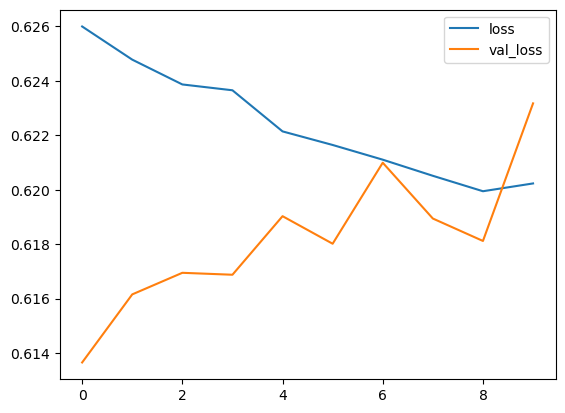

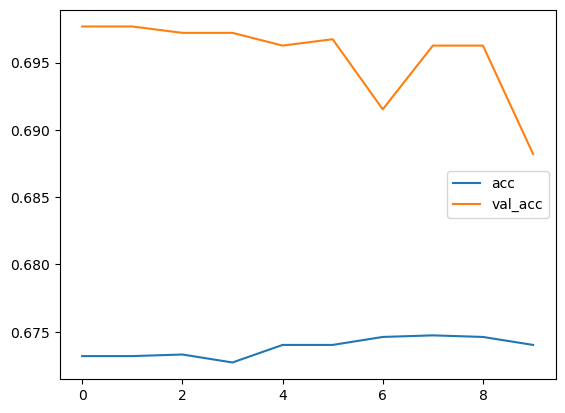

In [33]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

plt.plot(r.history['accuracy'],label='acc')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

#overfitting
#dataset is very small

In [34]:
from keras.layers import Input,GlobalMaxPooling1D, Conv1D
from keras.layers import MaxPooling1D
from keras.models import Model

In [33]:
BATCH_SIZE = 128

In [36]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH))
x = embedding_layer(input_)
x = Conv1D(128,3,activation = 'relu')(x)#filter size = batch_size 
#har word ki ek matrix.Convolution layer har matrix ko tiniest parts mein break karke most 
#intricate details nikalega..in sentiment analysis..it basically breaks a word into n grams
x = MaxPooling1D(3)(x)
x = Conv1D(128,3,activation = 'relu')(x)#relu = f(x)=max(x,0)
x = MaxPooling1D(3)(x)
x = Conv1D(128,3,activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)
x= Dense(128,activation='relu')(x)
output = Dense(len(possible_labels),activation ='softmax')(x)
model = Model(input_,output)
model.compile(loss = 'binary_crossentropy',optimizer ='rmsprop',
              metrics=['accuracy'])
print('Training model...')
r = model.fit(data,targets,batch_size=BATCH_SIZE,epochs=EPOCHS,
             validation_split= VALIDATION_SPLIT)

Training model...
Epoch 1/10
22/22 [==============================] - 40s 176ms/step - loss: 0.5154 - accuracy: 0.6924 - val_loss: 0.4716 - val_accuracy: 0.5270
Epoch 2/10
22/22 [==============================] - 1s 60ms/step - loss: 0.4725 - accuracy: 0.7144 - val_loss: 0.4528 - val_accuracy: 0.6875
Epoch 3/10
22/22 [==============================] - 1s 60ms/step - loss: 0.4638 - accuracy: 0.7041 - val_loss: 0.4482 - val_accuracy: 0.5682
Epoch 4/10
22/22 [==============================] - 1s 59ms/step - loss: 0.4553 - accuracy: 0.6718 - val_loss: 0.4438 - val_accuracy: 0.6690
Epoch 5/10
22/22 [==============================] - 1s 59ms/step - loss: 0.4458 - accuracy: 0.6686 - val_loss: 0.4507 - val_accuracy: 0.5057
Epoch 6/10
22/22 [==============================] - 1s 60ms/step - loss: 0.4342 - accuracy: 0.6647 - val_loss: 0.4581 - val_accuracy: 0.4943
Epoch 7/10
22/22 [==============================] - 1s 66ms/step - loss: 0.4263 - accuracy: 0.6543 - val_loss: 0.4509 - val_accuracy: 

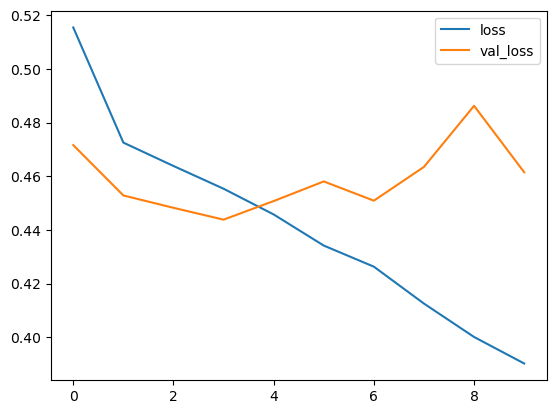

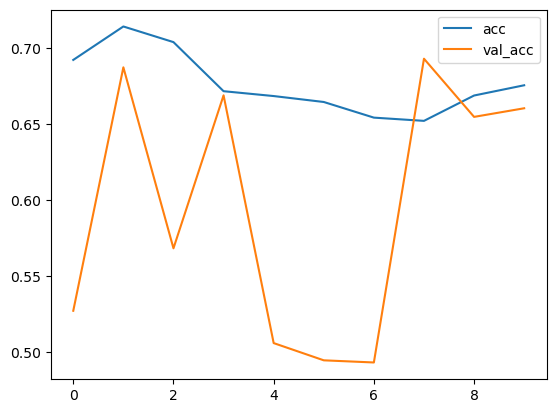

In [37]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

plt.plot(r.history['accuracy'],label='acc')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()


In [35]:
from keras.layers import Activation, Flatten
BATCH_SIZE = 64

In [39]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
model = Sequential()
model.add(Embedding(num_words,
                         EMBEDDING_DIM,
                         weights = [embedding_matrix],
                        input_length = MAX_SEQUENCE_LENGTH,
                         trainable=False)) 
model.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=(None, 1))))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.add(Flatten())
adam = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) 
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 300)          4480200   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 100, 128)          186880    
_________________________________________________________________
dropout_9 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)               

In [40]:
r = model.fit(data,targets,batch_size=BATCH_SIZE,epochs=EPOCHS,
             validation_split= VALIDATION_SPLIT)

Epoch 1/10
44/44 [==============================] - 22s 173ms/step - loss: 0.6419 - accuracy: 0.6701 - val_loss: 0.6177 - val_accuracy: 0.6977
Epoch 2/10
44/44 [==============================] - 5s 107ms/step - loss: 0.6339 - accuracy: 0.6731 - val_loss: 0.6148 - val_accuracy: 0.6977
Epoch 3/10
44/44 [==============================] - 5s 107ms/step - loss: 0.6332 - accuracy: 0.6731 - val_loss: 0.6111 - val_accuracy: 0.6977
Epoch 4/10
44/44 [==============================] - 5s 109ms/step - loss: 0.6323 - accuracy: 0.6731 - val_loss: 0.6121 - val_accuracy: 0.6977
Epoch 5/10
44/44 [==============================] - 5s 106ms/step - loss: 0.6314 - accuracy: 0.6731 - val_loss: 0.6122 - val_accuracy: 0.6977
Epoch 6/10
44/44 [==============================] - 5s 105ms/step - loss: 0.6310 - accuracy: 0.6731 - val_loss: 0.6125 - val_accuracy: 0.6977
Epoch 7/10
44/44 [==============================] - 5s 106ms/step - loss: 0.6311 - accuracy: 0.6731 - val_loss: 0.6127 - val_accuracy: 0.6977
Epoch

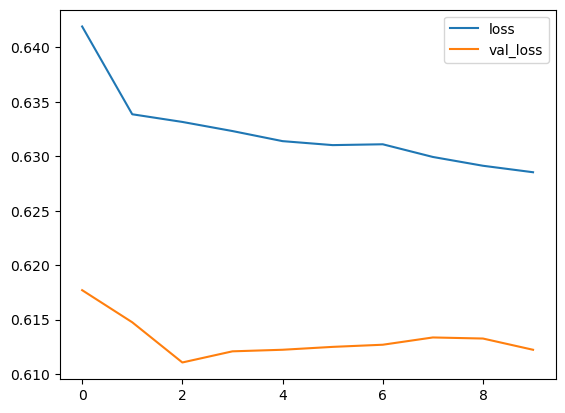

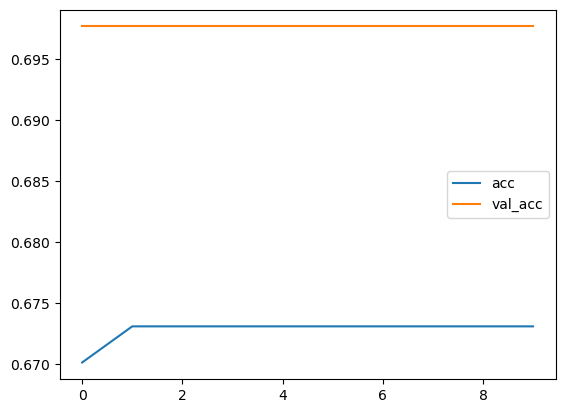

In [41]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

plt.plot(r.history['accuracy'],label='acc')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()


In [42]:
# inputs hai unke weights training mein update na ho

In [ ]:
#isse yeh hoga ki jo tumhare model hai uski overfitting reduce hogi